In [1]:
## Initialization and imports
import pandas as pd 
import numpy as np 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib import pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'

## Set random seed
np.random.seed(seed=14)

In [2]:
## Read in pickle data
ing_freq = pd.read_pickle("../model/user_f_df.p")
ing_freq.sample(3)

,almonds,rice pudding (extra),zafran,jasmine rice,sea salt,salsa roja,horseradish cream,tuna,"soya, dark beer, peas, tomato paste, pepper",sake,...,blackberry,xanthan,coconut cream,mediterranean herbs,thyme,plantain,pomegranate juice,smoked bacon (pork),olive oil,cust_id
1646,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.750,0030N00002oRiVgQAK
2071,0.134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.067,0.0,0.0,0.0,0.402,0030N00002mSfyMQAS
1781,0.071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.284,0030N00002LQpIPQA1


In [3]:
ing_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 0 to 2149
Columns: 976 entries, almonds to cust_id
dtypes: float64(975), object(1)
memory usage: 16.0+ MB


In [4]:
## Need to scale the features for clustering (distance metric)
def scale_df(df):
    for col in df.columns:
        if col != 'cust_id':
            df[col] = (df[col] - df[col].mean())/df[col].std()
    return df
        
ing_freq = scale_df(ing_freq)

In [25]:
## Exploring which ingredients are the most and least used
cols = ing_freq.columns
ing_means = ing_freq[cols].mean()  ## The variance in frequency would indicate strong preferences on ingredient
top_ings = ing_means.sort_values().index.values[:]  ## Choosing the x ingredients with the most variance

top_ing_f = ing_freq[top_ings]
top_ing_f.sample(4)

,corn flour,sweet potato,mango,red pepper,red onions,coriander,oregano,cream,capers,red cabbage,...,sesame,eggplant,white basmati rice,lemon,zucchini,cucumber,potatoes,tomato,parsley,olive oil
1378,2.793085,-0.672429,-0.709558,-0.722179,4.043970,1.118477,-0.876511,-0.211729,-0.671509,-0.845913,...,-1.124936,0.931213,-0.403845,-0.702925,-0.146294,-0.483232,-0.264342,0.719638,-0.478557,-1.713401
923,2.314939,-0.672429,-0.709558,-0.722179,-0.737171,0.360714,-0.876511,-0.949429,-0.671509,-0.845913,...,-0.339102,-1.162720,-1.134526,1.048155,-0.362550,2.631390,0.826737,0.334757,-0.673430,0.405060
59,-0.769877,-0.672429,2.578690,0.174860,-0.737171,0.088137,-0.436218,0.966674,0.191871,-0.173088,...,-0.339102,2.463138,0.288878,-1.087308,2.427843,-0.850402,-0.141677,-0.596407,-0.044808,0.405060
2076,-0.152914,-0.072333,-0.051908,-0.722179,-0.116243,-0.075409,0.180193,-0.566208,-0.671509,0.230607,...,0.427566,-1.162720,-0.375377,0.193970,-1.199668,0.858841,-0.980968,-0.906795,-1.176328,-0.654171


#### Kmeans clustering

In [34]:
## Assinging the features to X
X = top_ing_f.values

## Kmeans object with cluster rows are clusters and cols are feature coords
kmeans = KMeans(n_clusters=3, random_state=0, n_jobs=-1).fit(X)

In [35]:
## Print the top words from each topic
def print_top_ingredients(centroid_data, vocab, n_top_words):
    
    ## Getting sorted indexs of feature importance
    sortedX = np.argsort(centroid_data, axis = 1)
    
    ## Printing top words in each 'topic'
    for i, row in enumerate(sortedX[:, -1:-n_top_words-1:-1]):
        print("Topic", i,':', ', '.join([vocab[i] for i in row]))

In [36]:
print_top_ingredients(kmeans.cluster_centers_, top_ings, 7)

Topic 0 : carrot, sugar, olive oil, zucchini, lemon, eggplant, yoghurt (dairy)
Topic 1 : yogurt, chickpea, indian spices, carrots, curry, ground beef, lemonjuice
Topic 2 : caramelized sugar, dextrose, bouillon, wheat protein, soy protein, roasted potatoes, banana


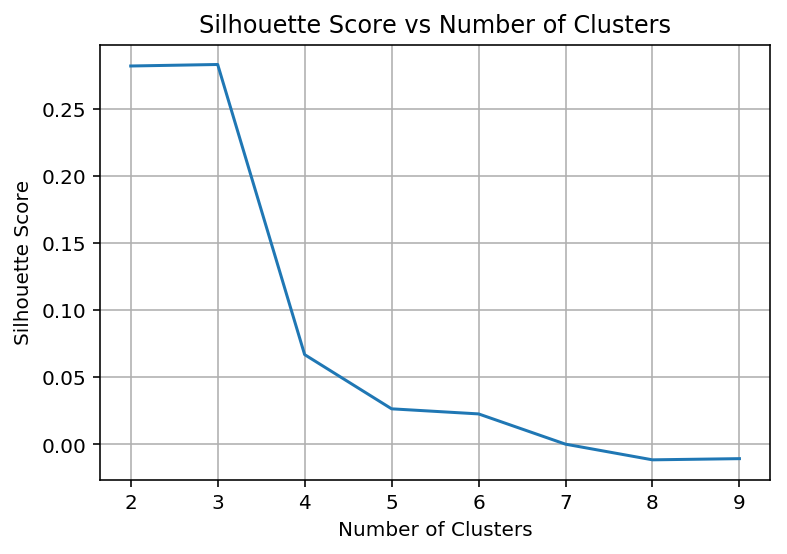

In [37]:
## Scoring Kmeans

## Running kmeans
def run_kmeans(data, n):
    kmeans = KMeans(n_clusters=n, random_state=0, n_jobs=-1).fit(data)
    
    return silhouette_score(data, kmeans.labels_)


## Finds the opitmal k value
def find_k(data, k):
    sil_scores = []
    for i in range(2, k):
        scores = (run_kmeans(data, i))
        sil_scores.append(scores)
        
    return sil_scores 

sils = find_k(X, 10)

plt.title("Silhouette Score vs Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xlabel("Number of Clusters")
plt.grid()
plt.plot(range(2, len(sils)+2), sils)

#### Hierarchical Clustering

In [13]:
def high_clustering(data, sample_size, dist_measure='cosine', plot='yes'):

    ## Selecting n random customers to look at
    trimmed_data = np.random.choice(range(data.shape[0]), sample_size)
    X = data.iloc[trimmed_data]

    ## Get vector distances (can be different measures) and squaring array
    Y = pdist(X, 'cosine')
    squareY = squareform(Y)

    ## Creates the linkage matrix with 
    return linkage(squareY, 'average')

## Plot the dendrogram
def plot_dendro(Z, orient='top', thresh=None, font_s=20):
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z)

    section = np.array(dn["ivl"]).astype(int)

    dn = dendrogram(Z, 
                    orientation=orient,
                    color_threshold=thresh,
                    leaf_font_size=font_s)
    plt.ylabel('Threshold')
    plt.xlabel('User')
    plt.title('User Ingredient Frequency Dendrogram')
    plt.show()

/Users/nschumacher/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


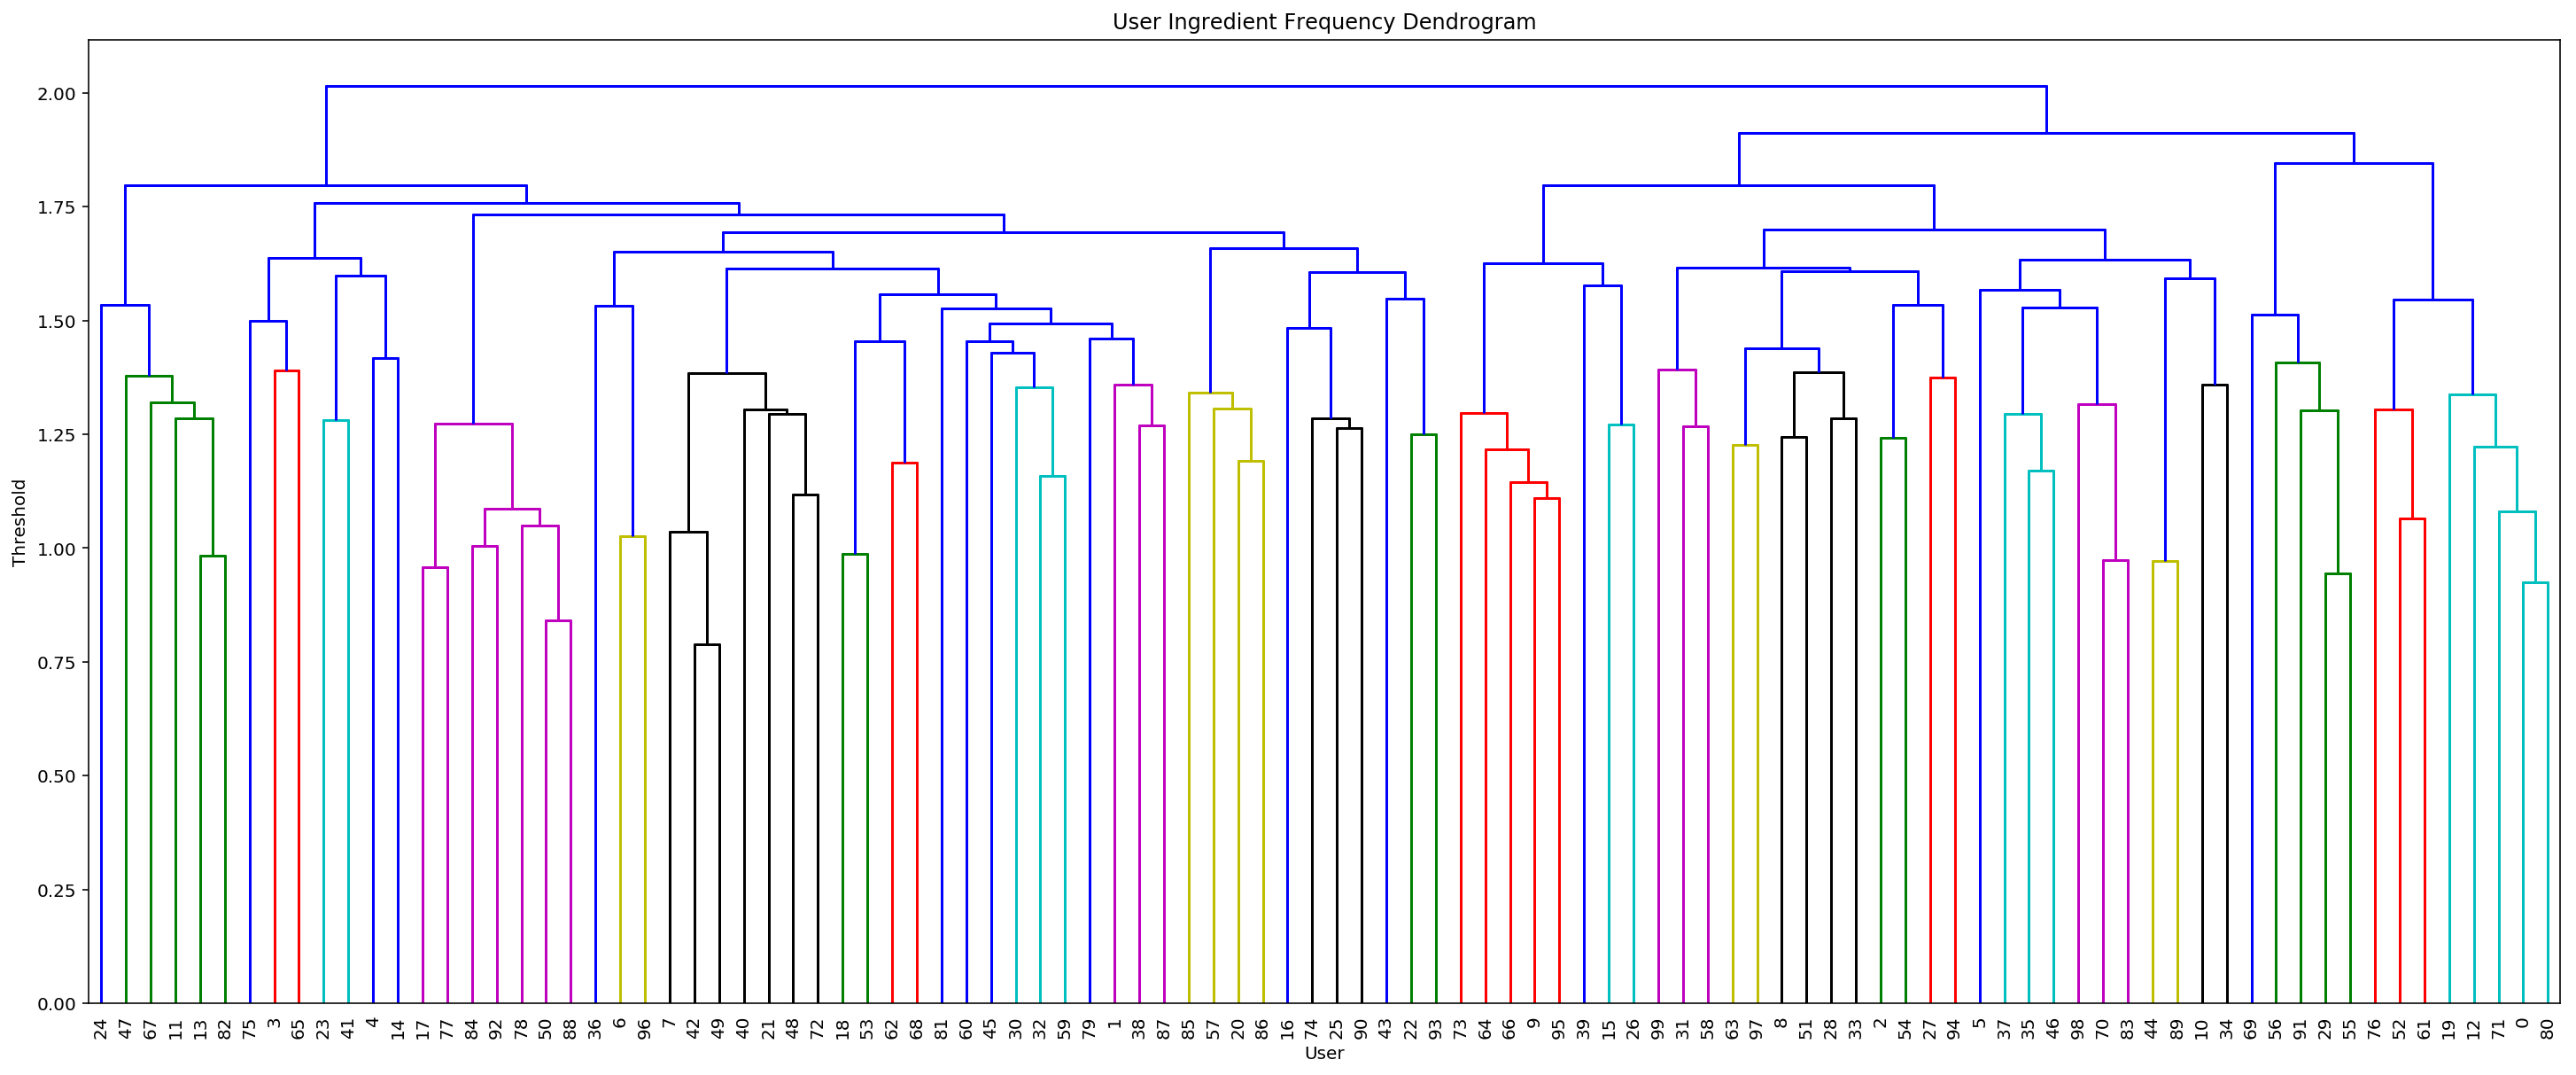

In [14]:
linkage1 = high_clustering(top_ing_f, 100)
plot_dendro(linkage1, orient='top', font_s=10)